In [1]:
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns; sns.set()

In [2]:
import logging

LOG_LEVEL = "INFO"
LOG_FORMAT = '%(asctime)-15s %(levelname)-9s %(name)s: %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, LOG_LEVEL))

log = logging.getLogger("mcmc")

# Metropolis-Hastings

In [14]:
# Target distribution / Samples
samples_num = 1000
xs = np.random.normal(loc=0.5, size=samples_num)
xs.shape

# Proposal distribution
def proposal_dist(x, y):
    "Returns p(x | y)."
    # in this case they're independent, sooo
    return stats.norm.pdf(x)

# Acceptance distribution
def acceptance_ratio(loc, loc_new):
    log_likelihood = np.sum(np.log(stats.norm.pdf(xs, loc=loc)))
    log_likelihood_new = np.sum(np.log(stats.norm.pdf(xs, loc=loc_new)))
    ratio = (log_likelihood_new - log_likelihood) + np.log(proposal_dist(loc, loc_new) / proposal_dist(loc_new, loc))
    return ratio

# Accept / reject
def accept_reject(loc, loc_new):
    u = np.random.uniform()
    acceptance_dist = np.min((0.0, acceptance_ratio(loc, loc_new)))
    if np.log(u) <= acceptance_dist:
        return loc_new
    else:
        return loc

In [15]:
accept_reject(0.99, 1.10)

0.99

In [16]:
acceptance_ratio(1.0, 4.0)

-6036.984182011929

In [17]:
class MetropolisHastingsSampler:
    def __init__(self, proba, proposal_proba, proposal_sample, initial_params=None):
        # parametrizable probability distribution proba(data, params)
        self.proba = proba

        # functions for sampling and computing probability of transitions
        self.proposal_sample = proposal_sample
        self.proposal_proba = proposal_proba

        # parameters
        self.current = initial_params

        # cache this result
        self._log_likelihood_cache = None

    def _log_likelihood(self, xs, params):
        return np.sum(np.log(self.proba(xs, params)))

    def acceptance_ratio(self, xs, current, proposed):
        log_likelihood_prop = np.sum(np.log(self.proba(xs, proposed)))

        if self._log_likelihood_cache is None:
            self._log_likelihood_cache = self._log_likelihood(xs, current)

        ratio = (log_likelihood_prop - self._log_likelihood_cache) \
            + np.log(self.proposal_proba(current, proposed) / self.proposal_proba(proposed, current))
            
        return ratio

    def accept_reject(self, xs, current, proposed):
        u = np.random.uniform()
        acceptance_dist = np.min((0.0, self.acceptance_ratio(xs, current, proposed)))

        # can't take log of 0.0 yo
        if u <= 0.0:
            return current
        
        if np.log(u) <= acceptance_dist:
            return proposed
        else:
            return current

    def sample(self):
        return self.proposal_sample(self.current)

    def step(self, xs, update=False):
        proposed = self.sample()
        return self.accept_reject(xs, self.current, proposed)

    def run(self, xs, n=10000, burnin=1000):
        if self.current is None:
            self.current = self.sample()

        if self._log_likelihood_cache is None:
            self._log_likelihood_cache = self._log_likelihood(xs, self.current)

        # perform burnin
        for i in range(burnin):
            new = self.step(xs)
            if new != self.current:
                self.current = new
                self._log_likelihood_cache = self._log_likelihood(xs, self.current)

        # store results
        results = np.zeros(n)
        results[0] = self.current

        for i in range(1, n):
            new = self.step(xs)
            results[i] = new
            
            if new != self.current:
                self.current = new
                self._log_likelihood_cache = self._log_likelihood(xs, self.current)

        for i in range(1, n):
            new = self.step(xs)
            if new != self.current:
                self.current = new
                self._log_likelihood_cache = self._log_likelihood(xs, self.current)
                
            results[i] = new

        return results

## Run

In [18]:
def proba_(xs, loc):
    return stats.norm.pdf(xs, loc)


def proposal_proba_(x, y):
    return stats.norm.pdf(x, loc=y)


def proposal_sample_(x):
    return stats.norm.rvs(loc=x)

sampler = MetropolisHastingsSampler(proba_, proposal_proba_, proposal_sample_, initial_params=0.0)

In [19]:
# without burnin
results = sampler.run(xs, n=1000, burnin=0)

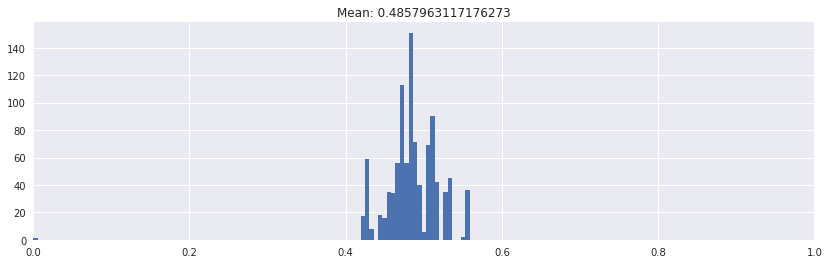

In [23]:
fig = plt.figure(figsize=(14, 4))
plt.hist(results, bins=100)
plt.title(f"Mean: {np.mean(results)}")
_ = plt.xlim(0, 1)

# Gibbs Sampling

In [24]:
class GibbsSampler:
    def __init__(self, proba, proposal_proba, proposal_sample, initial_params=None):
        # parametrizable probability distribution proba(data, params)
        self.proba = proba

        # functions for sampling and computing probability of transitions
        self.proposal_sample = proposal_sample
        self.proposal_proba = proposal_proba

        self.variables_num = len(self.proposal_sample)
        self.variable_indices = np.arange(self.variables_num)

        # parameters
        self.current = initial_params or self.intialize_variables()

        # cache this result
        self._log_likelihood_cache = []

        self._epsilon = np.finfo(np.float32).eps

    def initialize_variables(self):
        return []

    def _log_likelihood(self, xs, params):
        return np.sum(np.log(self.proba(xs, params) + self._epsilon))

    def acceptance_ratio(self, xs, current, proposed, var_idx):
        # Acceptance ratio should be computed CONDITIONED on the other variables
        full_proposed = current.copy()
        full_proposed[var_idx] = proposed
        log_likelihood_prop = np.sum(np.log(self.proba(xs, full_proposed) + self._epsilon))

        if self._log_likelihood_cache is None:
            self._log_likelihood_cache[var_idx] = self._log_likelihood(xs, current)

        ratio = (log_likelihood_prop - self._log_likelihood_cache[var_idx]) \
            + np.log(self.proposal_proba[var_idx](current, full_proposed) + self._epsilon) \
            - np.log(self.proposal_proba[var_idx](full_proposed, current)  + self._epsilon)
            
        return ratio

    def accept_reject(self, xs, current, proposed, var_idx):
        """
        Returns
        -------
            val : same type as the random variable
                Single value which can be used as the next sample for the variable.
        """
        u = np.random.uniform()
        acceptance_dist = np.min((0.0, self.acceptance_ratio(xs, current, proposed, var_idx)))

        # can't take log of 0.0 yo        
        if np.log(u + self._epsilon) <= acceptance_dist:
            return proposed
        else:
            return current[var_idx]

    def sample(self, var_idx):
        # CONDITIONED on fixed variables
        return self.proposal_sample[var_idx](self.current)

    def step(self, xs, update=False):
        res = np.zeros_like(xs)
        for idx in self.variable_indices:
            proposed = self.sample(idx)
            res[idx] = self.accept_reject(xs, self.current, proposed, idx)

        return res

    def run(self, xs, n=10000, burnin=1000):
        if not self.current:
            for idx in self.variable_indices:
                self.current.append(self.sample(idx))

        if not self._log_likelihood_cache:
            for idx in self.variable_indices:
                self._log_likelihood_cache.append(self._log_likelihood(xs, self.current))

        # perform burnin
        for i in range(burnin):
            for idx in self.variable_indices:
                new = self.step(xs, idx)
                if new[idx] != self.current[idx]:
                    self.current[idx] = new[idx]
                    self._log_likelihood_cache[idx] = self._log_likelihood(xs, self.current)

        # store results
        results = []
        results.append(self.current.copy())

        for i in range(1, n):
            for idx in self.variable_indices:
                new = self.step(xs, idx)
                if new[idx] != self.current[idx]:
                    self.current[idx] = new[idx]
                    self._log_likelihood_cache[idx] = self._log_likelihood(xs, self.current)

            results.append(self.current.copy())

        return results

In [25]:
def proba_(xs, loc_scale):
    return stats.norm.pdf(xs, loc=loc_scale[0], scale=loc_scale[1])


def proposal_proba_(x, y):
    return stats.norm.pdf(x, loc=y, scale=0.2)


def proposal_sample_(x):
    return stats.norm.rvs(loc=x, scale=0.2)

sampler = GibbsSampler(
    proba_,
    [lambda x, y: proposal_proba_(x[0], y[0]), lambda x, y: proposal_proba_(x[1], y[1])],
    [lambda x: proposal_sample_(x[0]), lambda x: proposal_sample_(x[1])],
    initial_params=[0.0, 2.0]
)

## Run

In [26]:
samples = sampler.run(xs, n=10000)

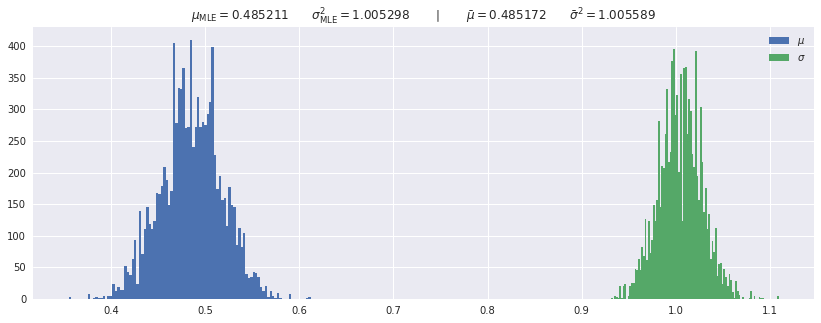

In [41]:
mle = np.mean(samples, axis=0)

fig = plt.figure(figsize=(14, 5))
_ = plt.hist([x[0] for x in samples], bins=100, label="$\mu$")
_ = plt.hist([x[1] for x in samples], bins=100, label="$\sigma$")

plt.title(r"$\mu_{\rm{MLE}} = %f \qquad \sigma_{\rm{MLE}}^2 = %f \qquad \mid \qquad \bar{\mu} = %f \qquad \bar{\sigma}^2 = %f$" % (mle[0], mle[1], np.mean(xs), np.var(xs)))

_ = plt.legend()